In [2]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
from scipy.stats import linregress
import numpy as np
import warnings
import talib as ta

In [3]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list


# 使用示例（假设raw_df为原始数据）：
# '2019-12-01'
date_list = generate_date_range('2025-01-01', '2025-01-15')
# print(date_list)
raw_df = []
for date in date_list:
    raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
    # raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/tardis/orderbook/ETHUSDT/binance_book_snapshot_5_{date}_ETHUSDT.csv.gz'))

raw_df = pd.concat(raw_df)
print(raw_df.head())
# print(raw_df.tail())

           id    price    qty    quote_qty           time  is_buyer_maker
0  4936628773  3336.58  6.583  21964.70614  1735689605058           False
1  4936628774  3336.57  0.033    110.10681  1735689605064            True
2  4936628775  3336.58  1.135   3787.01830  1735689605072           False
3  4936628776  3336.57  0.460   1534.82220  1735689605079            True
4  4936628777  3336.57  0.231    770.74767  1735689605079            True


In [4]:
def _ensure_datetime(series: pd.Series) -> pd.Series:
    # 若已是datetime类型，直接返回
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    
    # 安全转换为数值类型（非数值转为NaN，避免astype直接报错）
    s = pd.to_numeric(series, errors='coerce')
    
    # 检查是否存在无法转换的非数值
    if s.isna().any():
        warnings.warn("序列中包含无法转换为数值的元素，已自动转为NaT")
    
    # 避免空序列导致的判断错误
    if s.empty:
        return pd.Series([], dtype='datetime64[ns]')
    
    # 基于2025年前后的合理时间戳范围设置阈值（单位：对应单位的数量）
    # 参考：2025年的时间戳约为 1.7e9秒 ≈ 1.7e12毫秒 ≈ 1.7e15微秒 ≈ 1.7e18纳秒
    ns_threshold = 1e17  # 纳秒级阈值（约317年，覆盖合理时间范围）
    us_threshold = 1e14  # 微秒级阈值（约317年）
    ms_threshold = 1e11  # 毫秒级阈值（约317年）
    s_abs = s.abs()  # 用绝对值判断量级，保留原始符号用于转换（支持负时间戳）
    
    # 按any()逻辑判断单位（只要有一个元素满足阈值就用对应单位）
    if (s_abs > ns_threshold).any():
        return pd.to_datetime(s, unit='ns', errors='coerce')
    elif (s_abs > us_threshold).any():
        return pd.to_datetime(s, unit='us', errors='coerce')
    elif (s_abs > ms_threshold).any():
        return pd.to_datetime(s, unit='ms', errors='coerce')
    else:
        return pd.to_datetime(s, unit='s', errors='coerce')


In [5]:
def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    生成dollar bars，确保bar_id连续递增。
    
    改进点：
    1. 重构bar_id计算逻辑，通过跟踪累积成交额确保连续
    2. 避免因单笔大额交易导致的bar_id跳跃
    3. 仅过滤最后一个不完整的bar（若存在）
    """
    df = trades.copy()
    # 处理时间列和排序
    df['time'] = _ensure_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    
    # 计算成交额（quote_qty）
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    
    # 标记交易方向
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    df['buy_qty'] = df['qty'].where(df['trade_sign'] > 0, 0.0)
    df['sell_qty'] = df['qty'].where(df['trade_sign'] < 0, 0.0)
    
    # 核心改进：逐笔计算bar_id，确保连续递增
    cumulative = 0.0  # 累积成交额
    bar_id = 0        # 当前bar_id
    bar_ids = []      # 存储每个交易的bar_id
    
    for qty in df['quote_qty']:
        cumulative += qty
        # 当累积成交额达到阈值时，当前交易仍属于当前bar_id，随后bar_id递增并重置累积
        if cumulative >= dollar_threshold:
            bar_ids.append(bar_id)
            # 重置累积（保留超额部分，用于下一个bar的计算）
            cumulative -= dollar_threshold
            bar_id += 1
        else:
            bar_ids.append(bar_id)
    
    df['bar_id'] = bar_ids
    
    # 分组聚合
    agg = {
        'time': ['first', 'last'],
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'sum',
        'buy_qty': 'sum',
        'sell_qty': 'sum',
    }
    g = df.groupby('bar_id', sort=True).agg(agg)
    
    # 展平列名
    g.columns = [
        'start_time', 'end_time',
        'open', 'high', 'low', 'close',
        'volume', 'dollar_value',
        'buy_volume', 'sell_volume'
    ]
    
    # 仅过滤最后一个可能不完整的bar（若其成交额不足阈值）
    if not g.empty and g.iloc[-1]['dollar_value'] < dollar_threshold:
        g = g.iloc[:-1]
    
    # 重置bar_id为连续整数（避免因过滤最后一个bar导致的断档）
    g = g.reset_index(drop=True)
    g['bar_id'] = g.index
    
    return g

end_time
2025-01-01 00:00:00    11
2025-01-01 01:00:00     7
2025-01-01 02:00:00     7
2025-01-01 03:00:00     4
2025-01-01 04:00:00     9
                       ..
2025-01-15 19:00:00    55
2025-01-15 20:00:00    45
2025-01-15 21:00:00    14
2025-01-15 22:00:00    11
2025-01-15 23:00:00    14
Name: count, Length: 360, dtype: int64


<Axes: xlabel='end_time'>

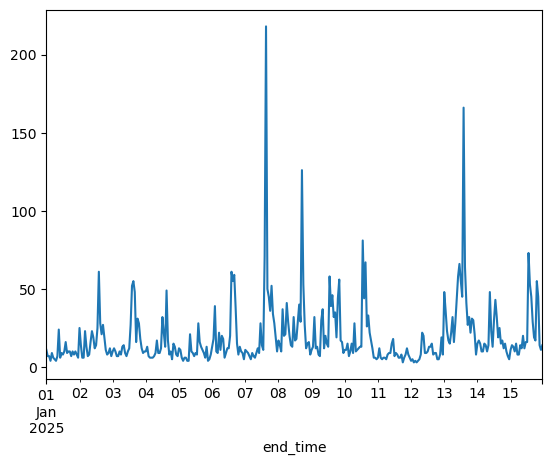

In [6]:
dollar_bar = build_dollar_bars(raw_df, 10000 * 2000)
hour_counts = dollar_bar.end_time.dt.floor('H').value_counts().sort_index()
print(hour_counts)
hour_counts.plot()

In [73]:
dollar_bar

,start_time,end_time,open,high,low,close,volume,dollar_value,buy_volume,sell_volume,bar_id
0,2025-01-01 00:00:05.058,2025-01-01 00:06:43.904,3336.58,3342.30,3334.76,3339.85,6002.782,2.004423e+07,3699.654,2303.128,0
1,2025-01-01 00:06:43.904,2025-01-01 00:15:08.662,3339.92,3348.47,3339.92,3347.32,5968.434,1.995665e+07,3870.481,2097.953,1
2,2025-01-01 00:15:08.736,2025-01-01 00:18:20.098,3347.33,3352.53,3346.79,3350.05,5973.024,2.001120e+07,3756.689,2216.335,2
3,2025-01-01 00:18:20.098,2025-01-01 00:26:56.601,3350.04,3353.00,3346.43,3348.29,5969.848,1.999717e+07,2974.099,2995.749,3
4,2025-01-01 00:26:56.602,2025-01-01 00:31:29.708,3348.29,3354.04,3345.99,3353.63,5969.753,2.000004e+07,4845.662,1124.091,4
...,...,...,...,...,...,...,...,...,...,...,...
16355,2025-02-01 23:43:46.718,2025-02-01 23:45:43.152,3127.46,3132.67,3126.16,3126.65,6392.456,2.000457e+07,3275.798,3116.658,16355
16356,2025-02-01 23:45:43.152,2025-02-01 23:48:55.876,3126.65,3129.70,3124.27,3127.10,6390.512,1.998271e+07,2921.100,3469.412,16356
16357,2025-02-01 23:48:56.029,2025-02-01 23:52:29.703,3127.10,3130.30,3123.68,3124.00,6625.378,2.071407e+07,2810.145,3815.233,16357
16358,2025-02-01 23:52:29.703,2025-02-01 23:54:04.619,3124.01,3124.19,3113.10,3113.88,6183.816,1.928931e+07,949.306,5234.510,16358


<Axes: >

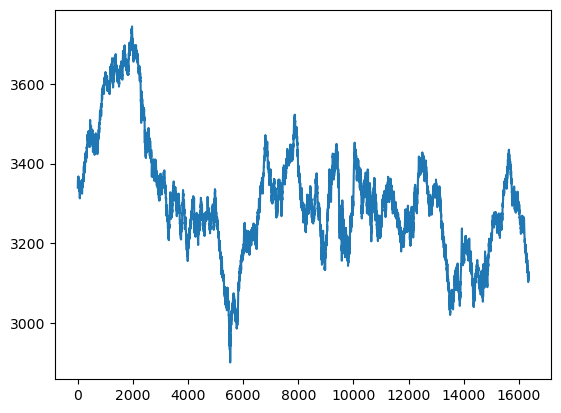

In [74]:
dollar_bar.close.plot()

In [75]:
def aggregate_trade_features_on_bars(
    trades: pd.DataFrame,
    bars: pd.DataFrame,
) -> pd.DataFrame:
    """
    将逐笔交易因子向量化聚合到 dollar bar 轴上（左闭右开）。
    - 使用 merge_asof 将每笔交易映射到对应 bar
    - 使用 groupby 聚合各项特征
    - 对空 bar 填充与原实现一致的约定值
    """
    # 预处理交易数据
    df = trades.copy()
    df['time'] = _ensure_datetime(df['time'])
    df = df.sort_values('time')
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)

    # 预处理 bars 并按 start_time 排序以便 asof 匹配
    bars2 = bars[[
        'bar_id', 'start_time', 'end_time', 'close'
    ]].copy().sort_values('start_time').reset_index(drop=True)

    # 将每笔交易匹配到最近且不晚于交易时间的 start_time，对应 bar 的候选
    df = pd.merge_asof(
        df,
        bars2[['bar_id', 'start_time', 'end_time']],
        left_on='time',
        right_on='start_time',
        direction='backward',
        allow_exact_matches=True
    )

    # 过滤不在 bar 窗口内的交易（左闭右开）
    valid_mask = df['time'] < df['end_time']
    df = df.loc[valid_mask].copy()

    # 若没有任何交易命中 bar，返回仅含 bars 基础信息与默认聚合值
    out = bars2.set_index('bar_id')[['start_time', 'end_time', 'close']].copy()
    duration_seconds = (out['end_time'] - out['start_time']).dt.total_seconds().clip(lower=1.0)

    if df.empty:
        out['trade_vwap'] = np.nan
        out['trade_volume_sum'] = 0.0
        out['trade_dollar_sum'] = 0.0
        out['trade_signed_volume'] = 0.0
        out['trade_buy_ratio'] = np.nan
        out['trade_intensity'] = 0.0
        out['trade_rv'] = np.nan
        return out[[
            'trade_vwap', 'trade_volume_sum', 'trade_dollar_sum', 'trade_signed_volume',
            'trade_buy_ratio', 'trade_intensity', 'trade_rv',
            'start_time', 'end_time', 'close'
        ]]

    # 计算辅助列并按 bar 聚合
    df['price_qty'] = df['price'] * df['qty']
    df['signed_qty'] = df['qty'] * df['trade_sign']
    df['buy_qty_part'] = df['qty'].where(df['trade_sign'] > 0, 0.0)

    g = df.groupby('bar_id', sort=False)
    sum_qty = g['qty'].sum()
    sum_dollar = g['quote_qty'].sum()
    sum_price_qty = g['price_qty'].sum()
    signed_volume = g['signed_qty'].sum()
    buy_qty_sum = g['buy_qty_part'].sum()
    counts = g.size()

    trade_vwap = sum_price_qty / sum_qty
    trade_buy_ratio = buy_qty_sum / sum_qty

    # 实现波动率（组内 log 价差平方和）
    df = df.sort_values(['bar_id', 'time'])
    df['logp'] = np.log(df['price'])
    df['logp_diff'] = df.groupby('bar_id')['logp'].diff()
    rv = df.groupby('bar_id')['logp_diff'].apply(lambda x: (x.dropna() ** 2).sum())

    # 组装输出，并对缺失 bar 使用默认值
    out['trade_vwap'] = trade_vwap
    out['trade_volume_sum'] = sum_qty
    out['trade_dollar_sum'] = sum_dollar
    out['trade_signed_volume'] = signed_volume
    out['trade_buy_ratio'] = trade_buy_ratio
    out['trade_intensity'] = counts.reindex(out.index).fillna(0.0) / duration_seconds
    out['trade_rv'] = rv

    out['trade_volume_sum'] = out['trade_volume_sum'].fillna(0.0)
    out['trade_dollar_sum'] = out['trade_dollar_sum'].fillna(0.0)
    out['trade_signed_volume'] = out['trade_signed_volume'].fillna(0.0)
    out['trade_intensity'] = out['trade_intensity'].fillna(0.0)
    # vwap、buy_ratio、rv 保留 NaN 以指示该 bar 无成交

    return out[[
        'trade_vwap', 'trade_volume_sum', 'trade_dollar_sum', 'trade_signed_volume',
        'trade_buy_ratio', 'trade_intensity', 'trade_rv',
        'start_time', 'end_time', 'close'
    ]]


In [76]:
dollar_bar

,start_time,end_time,open,high,low,close,volume,dollar_value,buy_volume,sell_volume,bar_id
0,2025-01-01 00:00:05.058,2025-01-01 00:06:43.904,3336.58,3342.30,3334.76,3339.85,6002.782,2.004423e+07,3699.654,2303.128,0
1,2025-01-01 00:06:43.904,2025-01-01 00:15:08.662,3339.92,3348.47,3339.92,3347.32,5968.434,1.995665e+07,3870.481,2097.953,1
2,2025-01-01 00:15:08.736,2025-01-01 00:18:20.098,3347.33,3352.53,3346.79,3350.05,5973.024,2.001120e+07,3756.689,2216.335,2
3,2025-01-01 00:18:20.098,2025-01-01 00:26:56.601,3350.04,3353.00,3346.43,3348.29,5969.848,1.999717e+07,2974.099,2995.749,3
4,2025-01-01 00:26:56.602,2025-01-01 00:31:29.708,3348.29,3354.04,3345.99,3353.63,5969.753,2.000004e+07,4845.662,1124.091,4
...,...,...,...,...,...,...,...,...,...,...,...
16355,2025-02-01 23:43:46.718,2025-02-01 23:45:43.152,3127.46,3132.67,3126.16,3126.65,6392.456,2.000457e+07,3275.798,3116.658,16355
16356,2025-02-01 23:45:43.152,2025-02-01 23:48:55.876,3126.65,3129.70,3124.27,3127.10,6390.512,1.998271e+07,2921.100,3469.412,16356
16357,2025-02-01 23:48:56.029,2025-02-01 23:52:29.703,3127.10,3130.30,3123.68,3124.00,6625.378,2.071407e+07,2810.145,3815.233,16357
16358,2025-02-01 23:52:29.703,2025-02-01 23:54:04.619,3124.01,3124.19,3113.10,3113.88,6183.816,1.928931e+07,949.306,5234.510,16358


In [77]:
trade_feat = aggregate_trade_features_on_bars(raw_df, dollar_bar)


In [78]:
def calculate_high_freq_downside_ratio_by_bars(
    df_minute_returns: pd.DataFrame,
    lookback_bars: int = 480  # 回溯的bar数量（如2个交易日=480分钟）
) -> pd.DataFrame:
    """
    基于bar数量计算“高频下行波动占比”因子
    
    参数：
    df_minute_returns: 分钟级收益DataFrame，index为时间（含时分），columns为股票代码，值为分钟收益
    lookback_bars: 计算因子时的回溯bar数量（如480=2个交易日×240分钟）
    
    返回：
    factor_df: 因子值DataFrame，index为分钟级时间戳，columns为股票代码
               每个时间点的值表示“过去lookback_bars个bar的下行波动占比均值”
    """
    # ---------- 步骤1：分离“下行收益” ----------
    # 仅保留收益<0的部分（收益≥0时置为0）
    downside_returns = df_minute_returns.where(df_minute_returns < 0, 0)
    
    # ---------- 步骤2：计算“下行收益平方”与“总收益平方” ----------
    downside_returns_squared = downside_returns **2  # 下行收益的平方
    total_returns_squared = df_minute_returns** 2    # 所有收益的平方
    
    # ---------- 步骤3：滚动窗口计算“下行波动占比” ----------
    # 滚动窗口内的下行平方和
    rolling_downside_sum = downside_returns_squared.rolling(window=lookback_bars, min_periods=lookback_bars).sum()
    # 滚动窗口内的总平方和
    rolling_total_sum = total_returns_squared.rolling(window=lookback_bars, min_periods=lookback_bars).sum()
    
    # 下行波动占比 = 下行平方和 / 总平方和
    factor_df = rolling_downside_sum / rolling_total_sum
    
    # 处理除零情况（总平方和为0时置为NaN）
    factor_df = factor_df.replace([np.inf, -np.inf], np.nan)
    
    return factor_df

In [49]:
for period in range(1, 30, 2):
    dollar_bar['ret_{}'.format(period)] = dollar_bar.close.shift(-period)/dollar_bar.close - 1
dollar_bar.columns[dollar_bar.columns.str.contains('ret', case=False)]

Index(['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret_15', 'ret_30', 'ret_7',
       'ret_9', 'ret_11', 'ret_13', 'ret_17', 'ret_19', 'ret_21', 'ret_23',
       'ret_25', 'ret_27', 'ret_29'],
      dtype='object')

In [50]:
ic_decay_list = []
mask = dollar_bar.columns
for i in dollar_bar.columns[dollar_bar.columns.str.contains('ret', case=False)]:
    ic_decay_list.append(dollar_bar['high_freq_downside_ratio_norm'].corr(dollar_bar[i]))
print(ic_decay_list)

[-0.009773279712428124, -0.0059693692439003795, 0.00570246719514166, 0.022109610527844784, 0.028189981615704667, 0.013566329798803118, 0.017084981654716298, 0.020635772742665315, 0.02516530650376823, 0.027771729966857915, 0.023499266150277913, 0.018117275185881004, 0.011533852075657618, 0.0076442768249120165, 0.006325686202801678, 0.009207448528698621, 0.0111493966157822]


In [64]:
net_value = 1+(high_freq_downside_ratio_norm_position_binning_position*dollar_bar['ret_5'].fillna(0)).cumsum()

<Axes: >

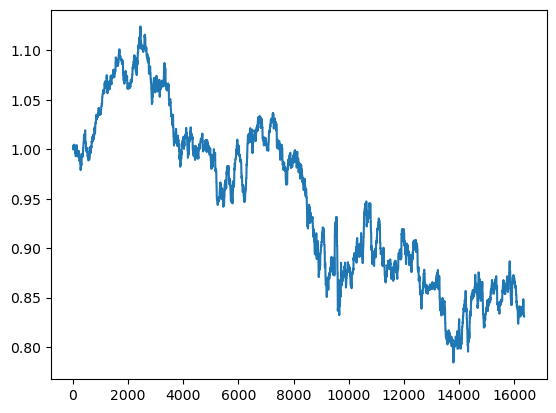

In [65]:
net_value.plot()